In [24]:
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [9]:
df0 = pd.read_csv("../testResults/test6.csv")
df0['time'] = pd.to_numeric(df0['time'])
df0['part.time'] = pd.to_numeric(df0['part.time'])
df0

,index,cfg,thread no.,time,part.time
0,0,./assets/spider0.sumocfg,1,579.507,-1.000
1,1,./assets/spider0.sumocfg,1,568.187,-1.000
2,2,./assets/spider0.sumocfg,1,581.950,-1.000
3,3,./assets/spider0.sumocfg,2,1435.970,2749.730
4,4,./assets/spider0.sumocfg,2,1555.710,1072.230
...,...,...,...,...,...
70,70,./assets/bologna-sim/osm.sumocfg,6,8829.350,833.801
71,71,./assets/bologna-sim/osm.sumocfg,6,9662.140,837.813
72,72,./assets/bologna-sim/osm.sumocfg,12,8821.790,6328.830
73,73,./assets/bologna-sim/osm.sumocfg,12,8192.860,866.215


In [20]:
df1 = df0.groupby(["cfg", "thread no."]).agg({
    'time': 'mean',
    'part.time': 'max'
}).reset_index()
df1["time"] = df1["time"].apply(lambda x: round(x / 1000, 2))

df1

,cfg,thread no.,time,part.time
0,./assets/bologna-sim/osm.sumocfg,1,8.30,12667.40
1,./assets/bologna-sim/osm.sumocfg,2,11.25,11000.20
2,./assets/bologna-sim/osm.sumocfg,4,11.39,9332.71
3,./assets/bologna-sim/osm.sumocfg,6,9.26,7530.98
4,./assets/bologna-sim/osm.sumocfg,12,8.40,6328.83
5,./assets/grid_large.sumocfg,1,83.78,-1.00
6,./assets/grid_large.sumocfg,2,41.15,107202.00
7,./assets/grid_large.sumocfg,4,23.42,108625.00
8,./assets/grid_large.sumocfg,6,18.67,98888.80
9,./assets/grid_large.sumocfg,12,13.03,97716.80


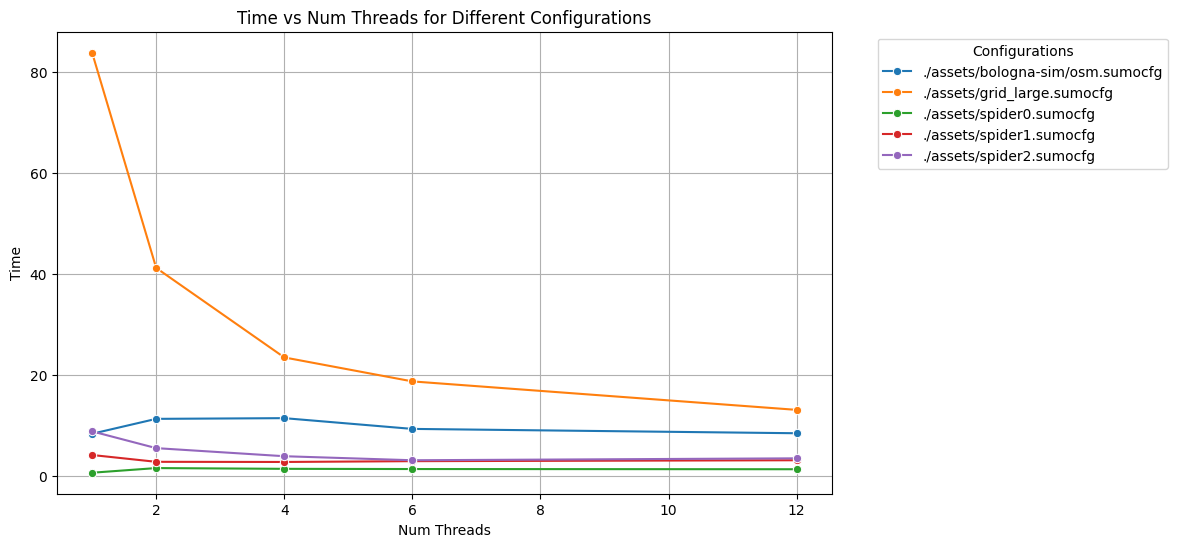

In [21]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df1, x='thread no.', y='time', hue='cfg', marker='o')
plt.title('Time vs Num Threads for Different Configurations')
plt.xlabel('Num Threads')
plt.ylabel('Time')
plt.legend(title='Configurations', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

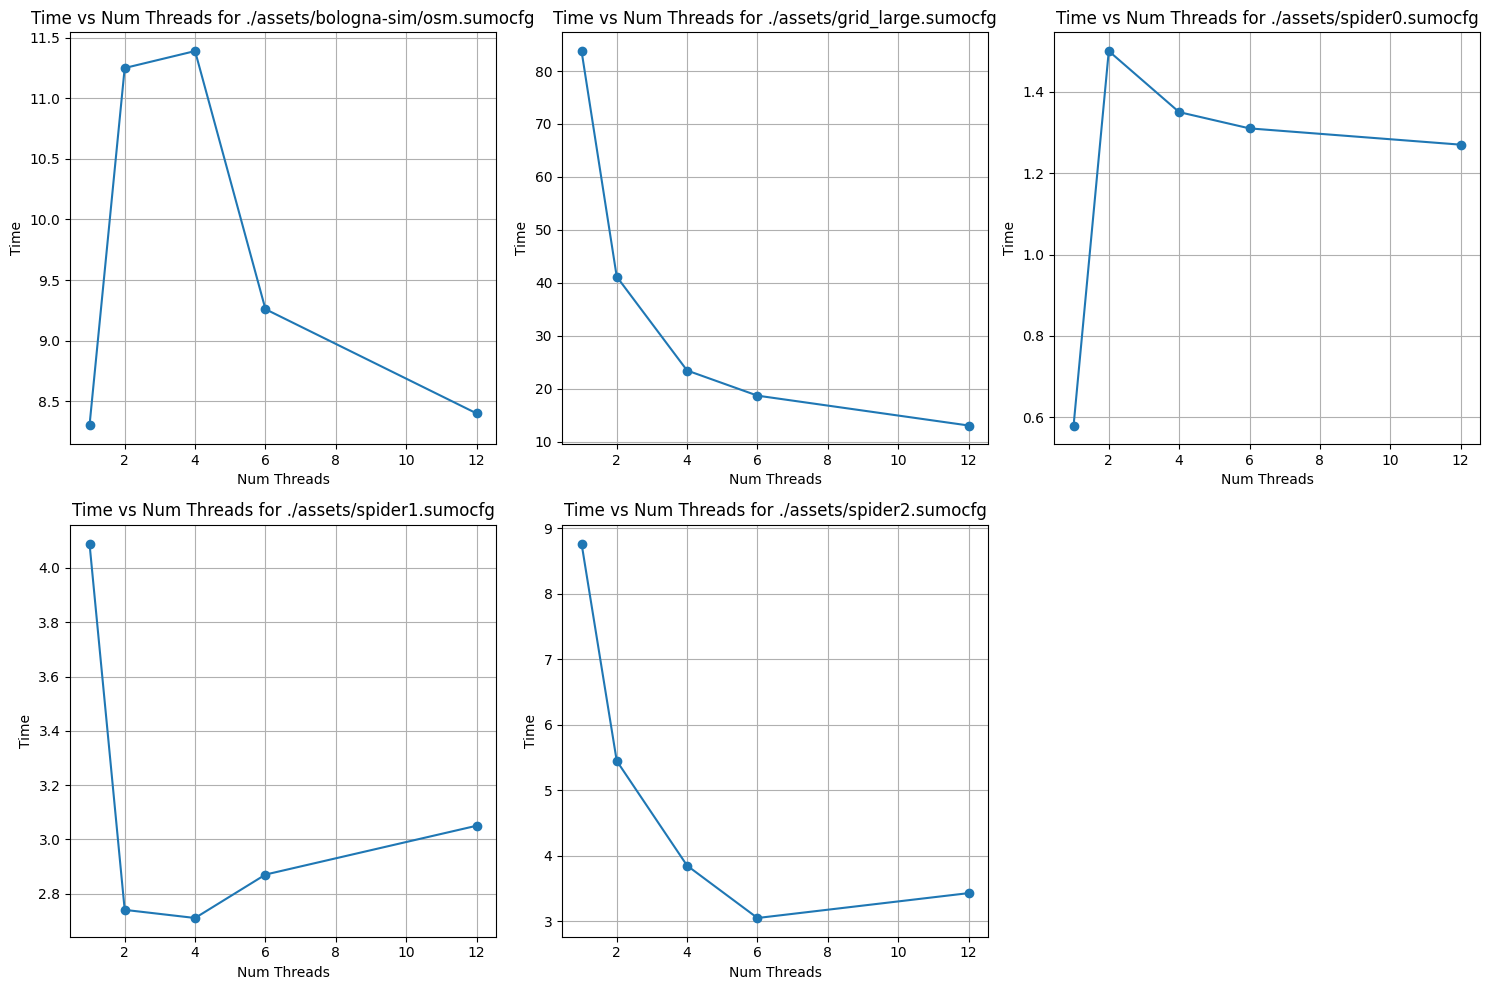

In [25]:
unique_configs = df1['cfg'].unique()
num_configs = len(unique_configs)
num_cols = 3  # Number of columns in the grid, you can adjust this

num_rows = int(np.ceil(num_configs / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for i, config in enumerate(unique_configs):
    row = i // num_cols
    col = i % num_cols
    data = df1[df1['cfg'] == config]
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.plot(data['thread no.'], data['time'], marker='o')
    ax.set_title(f'Time vs Num Threads for {config}')
    ax.set_xlabel('Num Threads')
    ax.set_ylabel('Time')
    ax.grid(True)

# Hide any empty subplots
for i in range(len(unique_configs), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    if num_rows > 1:
        axes[row, col].axis('off')
    else:
        axes[col].axis('off')

plt.tight_layout()
plt.show()